## Two Algorithms:

I have two versions of this algorithm 

1. Using laplace noise for all privacy noise. 
2. Using the google privacy accountant to get parameters for gaussian and discrete laplace noise. 

It would be interesting to see if using the gaussian and dlaplace noise instead makes any significant difference 

### Parameters 

- max_depth: How deep the LSH tree should be constructed
- branching_threshold: Minimum number of nodes required to branch
- include_threshold: Minimum number of nodes required to include in final coreset

Algorithm 1: The split of privacy over constructing tree and private averages (default 0.8/0.2)


In [14]:
import numpy as np 
import matplotlib.pyplot as plt
from bucket import create_bucket_synopsis, bucket_using_privacy_accountant, Params
from evaluation_utils import kmeans_loss
from lloyd import lloyd_with_weights

master_rng = np.random.default_rng(42)

def lsh_experiment(algo: int, data: np.ndarray, p: Params, n_trials: int = 20):
    s = master_rng.integers(low=0, high=100000)
    total_loss = 0
    n_successful_trials = n_trials
    for x in range(n_trials):
        if algo == 1:
            print("starting synopsis... ")
            private_points, private_weights = create_bucket_synopsis(data, p, s+x)
        else:
            private_points, private_weights = bucket_using_privacy_accountant(data, p, s+x)
        if private_points.shape[0] <= p.k: # if number of points is less than or equal to desired number of centers
            centers = private_points
        else:
            centers = lloyd_with_weights(k=p.k, X=private_points, weights=private_weights, n_iter=5, rs=s+x)
        try:
            loss = kmeans_loss(centers, data)
        except:
            loss = 0
            n_successful_trials -=1
        total_loss += loss
        print(f"Trial {x+1} done")
    print("Number completed trials: ", n_successful_trials)
    return total_loss / n_successful_trials


Algorithm 1 loss: 0.13752113271158034
Algorithm 2 loss: 0.13709611656806048


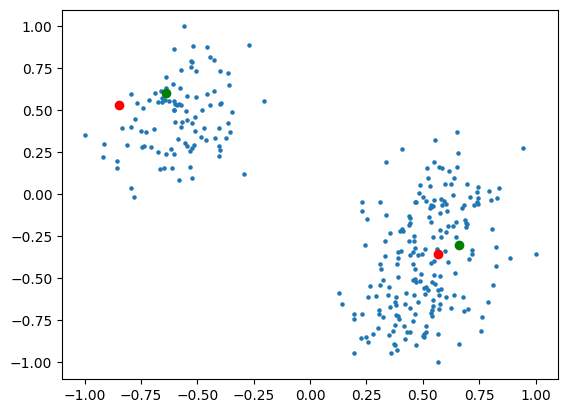

In [2]:
small = np.load("datasets/synthetic-gaussian.npy")
p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=15)
points1, weights1 = create_bucket_synopsis(small, p, seed=454)
points2, weights2 = bucket_using_privacy_accountant(small, p, seed=454)

# the algorithm only returns 2 points. since we wanted k=3, these points will just become the centers. 
plt.scatter(small[:,0], small[:,1], s=5)
plt.scatter(points1[:,0], points1[:,1], c="red")
plt.scatter(points2[:,0], points2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(points1, small)}")
print(f"Algorithm 2 loss: {kmeans_loss(points2, small)}")

max depth = 5 avg loss = 0.5143181307374742
max depth = 10 avg loss = 0.22169686048146542
max depth = 15 avg loss = 0.15218791393013312
Empty tree gives no centers setting loss to 1
max depth = 20 avg loss = 0.19613573593550737
max depth = 25 avg loss = 0.224526525475283
Empty tree gives no centers setting loss to 1
max depth = 30 avg loss = 0.22579617511845979


Text(0, 0.5, 'k-means loss')

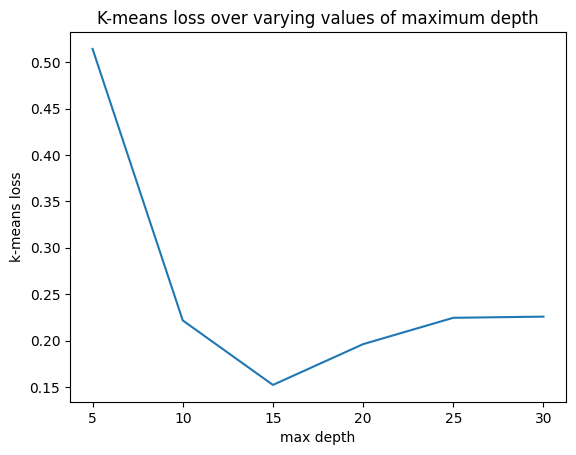

In [16]:
# vary max depth for default branching threshold, include threshold. Note that max depth has to be chosen before computing any noise so it cannot depend on the other parameters

values = [5, 10, 15, 20, 25, 30]
results = []

for d in values:
    p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=d)
    avg_loss = lsh_experiment(1, small, p, n_trials=50)
    print(f"max depth = {d} avg loss = {avg_loss}")
    results.append(avg_loss)

plt.plot(values, results)
plt.title("K-means loss over varying values of maximum depth")
plt.xlabel("max depth")
plt.ylabel("k-means loss")

In [6]:
# make a heatmap for max depth and include threshold 

n = small.shape[0] # 300

depths = [10, 12, 15, 17, 20, 22, 25, 27, 30]
includes = [40, 45,  50, 55, 60, 65, 70, 75, 80]
heatmap_results = np.empty((9,9))

for d_index in range(9):
    for i_index in range(9):
        print(d_index, i_index)
        p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=depths[d_index], include_threshold=includes[i_index])
        heatmap_results[d_index, i_index] = lsh_experiment(1, small, p, n_trials=20)

0 0
Trial 1 done
Trial 2 done
Trial 3 done
Trial 4 done
Trial 5 done
Trial 6 done
Trial 7 done
Trial 8 done
Trial 9 done
Trial 10 done
Trial 11 done
Trial 12 done
Trial 13 done
Trial 14 done
Trial 15 done
Trial 16 done
Trial 17 done
Trial 18 done
Trial 19 done
Trial 20 done
Number completed trials:  20
0 1
Trial 1 done
Trial 2 done
Trial 3 done
Trial 4 done
Trial 5 done
Trial 6 done
Trial 7 done
Trial 8 done
Trial 9 done
Trial 10 done
Trial 11 done
Trial 12 done
Trial 13 done
Trial 14 done
Trial 15 done
Trial 16 done
Trial 17 done
Trial 18 done
Trial 19 done
Trial 20 done
Number completed trials:  20
0 2
Trial 1 done
Trial 2 done
Trial 3 done
Trial 4 done
Trial 5 done
Trial 6 done
Trial 7 done
Trial 8 done
Trial 9 done
Trial 10 done
Trial 11 done
Trial 12 done
Trial 13 done
Trial 14 done
Trial 15 done
Trial 16 done
Trial 17 done
Trial 18 done
Trial 19 done
Trial 20 done
Number completed trials:  20
0 3
Trial 1 done
Trial 2 done
Trial 3 done
Trial 4 done
Trial 5 done
Trial 6 done
Trial 

KeyboardInterrupt: 

In [21]:
# depth 24
for i_index in range(9):
    d_index = 7
    print(d_index, i_index)
    p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=depths[d_index], include_threshold=includes[i_index])
    heatmap_results[d_index, i_index] = lsh_experiment(1, small, p, n_trials=20)


7 0
starting synopsis... 
Trial 1 done
starting synopsis... 
Trial 2 done
starting synopsis... 
Trial 3 done
starting synopsis... 
Trial 4 done
starting synopsis... 
Trial 5 done
starting synopsis... 
Trial 6 done
starting synopsis... 
Trial 7 done
starting synopsis... 
Trial 8 done
starting synopsis... 
Trial 9 done
starting synopsis... 
Trial 10 done
starting synopsis... 
Trial 11 done
starting synopsis... 
Trial 12 done
starting synopsis... 
Trial 13 done
starting synopsis... 
Trial 14 done
starting synopsis... 
Trial 15 done
starting synopsis... 
Trial 16 done
starting synopsis... 
Trial 17 done
starting synopsis... 
Trial 18 done
starting synopsis... 
Trial 19 done
starting synopsis... 
Trial 20 done
Number completed trials:  20
7 1
starting synopsis... 
Trial 1 done
starting synopsis... 
Trial 2 done
starting synopsis... 
Trial 3 done
starting synopsis... 
Trial 4 done
starting synopsis... 
Trial 5 done
starting synopsis... 
Trial 6 done
starting synopsis... 
Trial 7 done
startin

KeyboardInterrupt: 

In [17]:
print(heatmap_results)

[[2.58406611e-001 2.62803333e-001 1.12617884e-001 2.27036197e-001
  1.95677378e-001 2.17489537e-001 2.60129522e-001 1.67995867e-001
  1.89755694e-001]
 [1.98317040e-001 1.43964150e-001 1.20684462e-001 1.26172481e-001
  2.16802826e-001 2.28213182e-001 1.96619780e-001 2.77736847e-001
  2.94307528e-001]
 [1.82966961e-001 1.42288615e-001 1.68990515e-001 1.85891648e-001
  1.59080502e-001 1.89211948e-001 1.89734646e-001 2.29874682e-001
  2.04865724e-001]
 [2.79016605e-001 1.40697585e-001 1.41471049e-001 2.00444473e-001
  2.02318563e-001 2.53909305e-001 3.29793017e-001 2.97252288e-001
  2.84902265e-001]
 [1.43429835e-001 1.40344148e-001 1.48947297e-001 2.03142800e-001
  2.40366651e-001 2.24225527e-001 3.41332388e-001 2.67057705e-001
  3.32082898e-001]
 [2.18407477e-001 2.85135749e-001 1.28019273e-001 2.79145077e-001
  2.76074438e-001 2.40799620e-001 2.59447176e-001 1.70942705e-001
  2.72340506e-001]
 [5.97819431e-322 6.02760088e-322 6.07700744e-322 6.12641401e-322
  6.22522714e-322 6.27463370

In [4]:
heatmap_results_algo2 = np.empty((9,9))

for d_index in range(9):
    for i_index in range(9):
        print(d_index, i_index)
        p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=3, max_depth=depths[d_index], include_threshold=includes[i_index])
        heatmap_results[d_index, i_index] = lsh_experiment(2, small, p, n_trials=30)

0 0
Number completed trials:  20
0 1
Number completed trials:  28
0 2
Number completed trials:  29
0 3
Number completed trials:  27
0 4
Number completed trials:  25
0 5


KeyboardInterrupt: 

In [20]:
import seaborn as sns
import pandas as pd

hr = pd.DataFrame(heatmap_results, index=depths, columns=includes)
hr

,40,45,50,55,60,65,70,75,80
10,2.584066e-01,2.628033e-01,1.126179e-01,2.270362e-01,1.956774e-01,2.174895e-01,2.601295e-01,1.679959e-01,1.897557e-01
12,1.983170e-01,1.439641e-01,1.206845e-01,1.261725e-01,2.168028e-01,2.282132e-01,1.966198e-01,2.777368e-01,2.943075e-01
15,1.829670e-01,1.422886e-01,1.689905e-01,1.858916e-01,1.590805e-01,1.892119e-01,1.897346e-01,2.298747e-01,2.048657e-01
17,2.790166e-01,1.406976e-01,1.414710e-01,2.004445e-01,2.023186e-01,2.539093e-01,3.297930e-01,2.972523e-01,2.849023e-01
20,1.434298e-01,1.403441e-01,1.489473e-01,2.031428e-01,2.403667e-01,2.242255e-01,3.413324e-01,2.670577e-01,3.320829e-01
22,2.184075e-01,2.851357e-01,1.280193e-01,2.791451e-01,2.760744e-01,2.407996e-01,2.594472e-01,1.709427e-01,2.723405e-01
25,1.672945e-01,1.578341e-01,1.590415e-01,1.823810e-01,2.851067e-01,1.854516e-01,1.859739e-01,2.976004e-01,4.751533e-01
27,6.472260e-322,6.521667e-322,6.571073e-322,6.620480e-322,6.719293e-322,6.768699e-322,6.818106e-322,6.916919e-322,6.966326e-322
30,7.114545e-322,7.213358e-322,7.262765e-322,7.312172e-322,7.361578e-322,7.410985e-322,7.460391e-322,7.509798e-322,7.559204e-322


[Text(0.5, 23.52222222222222, 'Include Threshold'),
 Text(50.722222222222214, 0.5, 'Max Depth')]

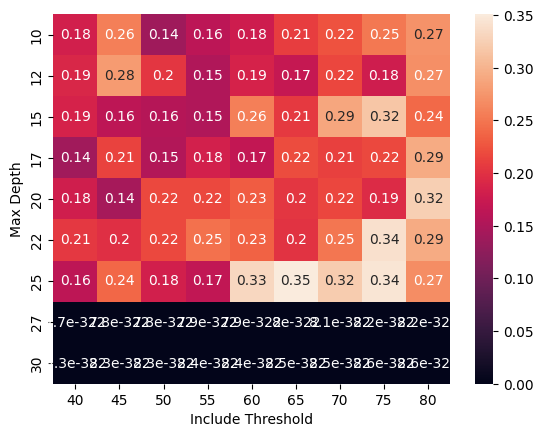

In [42]:
ax = sns.heatmap(hr, annot=True)
ax.set(xlabel="Include Threshold", ylabel="Max Depth")

### Airports Dataset

In [ ]:
airports = np.load("datasets/airports.npy")
p = Params(epsilon=1, delta=1e-6, radius=1, dimension=2, k=5)
points1, weights1 = create_bucket_synopsis(small, p, seed=421231)
points2, weights2 = bucket_using_privacy_accountant(small, p, seed=421231)

plt.scatter(airports[:,0], airports[:,1], s=5)
plt.scatter(points1[:,0], points1[:,1], c="red")
plt.scatter(points2[:,0], points2[:,1], c="green")

print(f"Algorithm 1 loss: {kmeans_loss(points1, airports)}")
print(f"Algorithm 2 loss: {kmeans_loss(points2, airports)}")